In [58]:
from __future__ import division

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

from os.path import join
import os

import torch
import torchvision.utils as vutils
from scipy.io import loadmat, savemat
import numpy as np
import argparse
from torch.autograd import Variable

from loaders import locations, getLoaders
from models import getModels
from scipy.stats import kendalltau # distance metrics between permutations


def extractPercentileStats(trainProbs, testProbs):
    sortedInds = np.argsort(np.concatenate([trainProbs, testProbs]))
    trainTest = np.concatenate([np.ones(len(trainProbs), dtype='int'),np.zeros(len(testProbs),dtype='int')])
    trainTest = trainTest[sortedInds]
    cumulative = np.cumsum(trainTest)
    testPercentiles = cumulative[trainTest==0]/float(len(trainProbs))
    return testPercentiles

def heatmapFlowgan(net, codesOnly=False, savePrefix='fig'):
    grid0, grid1 = np.meshgrid(np.linspace(-1.5,1.5,100),np.linspace(1.5,-1.5,100))
    print grid0.shape, grid1.shape
    pts = np.zeros((10000,2))
    for i in range(100):
        for j in range(100):
            pts[i*100+j,:] = grid0[i,j],grid1[i,j]
    ptsTorch = Variable(torch.from_numpy(pts.astype(np.float32)))
    vals, logp = net.invert(ptsTorch)
    
    if codesOnly:
        vals = vals.data.numpy()
        logpcodes = -0.5*np.sum(vals*vals,1)
        logpcodes = logpcodes.squeeze()
    #    if compareProbs:
        logpmodel = logp.data.numpy().squeeze()
        jacob = logpmodel-logpcodes
        print jacob.min(), jacob.max(), jacob.mean()
        plt.figure()
        plt.hist(jacob)
        plt.savefig(join(savePrefix,'histogram_jacobian.pdf'), dpi=500)
        
        plt.figure()
        plt.hist(logpcodes[logpcodes>-100])
        plt.savefig(join(savePrefix,'histogram_largest_codes.pdf'), dpi=500)
        
        inds1 = np.argsort(logpcodes)
        inds2 = np.argsort(logpmodel)
        print np.sum(inds1==inds2)
        print kendalltau(inds1, inds2)
            
        sortedModel = logpmodel[inds1]
        plt.figure()
        plt.plot(sortedModel, '.')
        plt.savefig(join(savePrefix,'logprobs_cross_sorted.pdf'), dpi=500)
            
        probsNumpyCodes = logpcodes.reshape((100,100))
        
              #  print probsNumpy[:5,:5]
        transformedCodes = np.exp(probsNumpyCodes)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformedCodes, extent=[-1.5,1.5,-1.5,1.5])
       # plt.ylim(-1.5, 1.5)
       # plt.xlim(-1.5, 1.5)
        plt.savefig(join(savePrefix,'heatmap_codes_only.png'), dpi=500)
        
        probsNumpy = logpmodel.reshape((100,100))
        transformed = np.exp(probsNumpy)
        plt.figure()
        plt.imshow(transformed, extent=[-1.5,1.5,-1.5,1.5])
        plt.savefig(join(savePrefix,'heatmap.png'), dpi=500)

            
    else:
        probsNumpy = logp.data.numpy().reshape((100,100))
        
          #  print probsNumpy[:5,:5]
        transformed = np.exp(probsNumpy)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformed, extent=[-1.5,1.5,-1.5,1.5])
        plt.savefig(join(savePrefix,'heatmap.png'), dpi=500)
    
def plotMogSamplesFlowgan(netG, npts, savePrefix='fig'):
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts, _ = netG(samples)
    pts = pts.data.numpy()
    plt.figure()
    plt.plot(pts[:,0], pts[:,1], '.')
    plt.savefig(join(savePrefix,'flowgan_samples.pdf'), dpi=500)
    
def plotMogSamples(netG, npts):
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts = netG(samples).data.numpy()
    plt.plot(pts[:,0], pts[:,1], '.')
    
def sortPlot(codeProbs, probs):
    inds = np.argsort(codeProbs)
    plt.figure()
    plt.plot(probs[inds], '.')
    
def hiLow(pdict, number=36, imageArray=None, nrow=6, resolution=5, classes=None, useCodeProbs=False, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    
    if imageArray is None:
        ims = pdict['images']
    else:
        ims = imageArray
        
    if useCodeProbs:
        probs = pdict['codeProbs'].squeeze()
    else:
        probs = pdict['probs'].squeeze()
    
    
    if classes is not None:
        unique = np.unique(classes)
        for v in unique:
            inds = np.argsort(probs[classes==v])
            imsRestricted = ims[classes==v]
            
            classInds = np.where((classes==v)[inds])[0]
           # print classes[classInds]
            imsTop = torch.from_numpy(imsRestricted[inds[-number:]])
            imsBot = torch.from_numpy(imsRestricted[inds[:number]])
            topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
            botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
            print "Class", v
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(topGrid.numpy().transpose((1,2,0)))
            plt.savefig(join(savePrefix, 'top_class_{}.png'.format(v)), dpi=500)
            plt.figure(figsize=(5,5))
            plt.axis('off')
            plt.imshow(botGrid.numpy().transpose((1,2,0)))
            plt.savefig(join(savePrefix, 'bottom_class_{}.png'.format(v)), dpi=500)
    else:
        inds = np.argsort(probs)
        imsTop = torch.from_numpy(ims[inds[-number:]])
        imsBot = torch.from_numpy(ims[inds[:number]])

        topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
        botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)

        #if hi:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(topGrid.numpy().transpose((1,2,0)))
        plt.savefig(join(savePrefix, 'top.png'), dpi=500)
        #else:
        plt.figure(figsize=(resolution,resolution))
        plt.axis('off')
        plt.imshow(botGrid.numpy().transpose((1,2,0)))
        plt.savefig(join(savePrefix, 'bottom.png'), dpi=500)
    
    

def percentiles(trainProbs, testProbs, bins=100, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    stats = extractPercentileStats(trainProbs, testProbs)
    plt.figure()
    plt.hist(stats, bins=bins)
    plt.savefig(join(savePrefix,'percentile_hist.pdf'), dpi=500)
    
    
def histogramOverlap(trainProbs, testProbs, trainLabel='train', testLabel='test', 
                     lowerThreshold=-10000, bins=100, savePrefix='fig'):
    if not os.path.isdir(savePrefix):
        os.makedirs(savePrefix)
    plt.figure()
    plt.hist(trainProbs[(trainProbs>lowerThreshold)], bins=bins, alpha=0.5, label=trainLabel)
    plt.hist(testProbs[(testProbs>lowerThreshold)], bins=bins, alpha=0.5, label=testLabel)
    plt.legend()
    plt.show()
    plt.savefig(join(savePrefix,'log_prob_cross_hist.pdf'), dpi=500)
    


(100, 100) (100, 100)
-0.7466736 3.4527664 1.4519408
455
KendalltauResult(correlation=0.0865983798379838, pvalue=1.4408608796086082e-38)


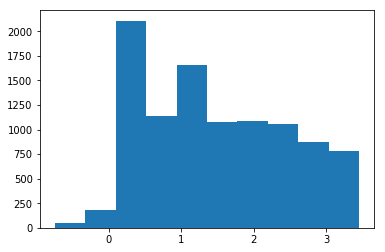

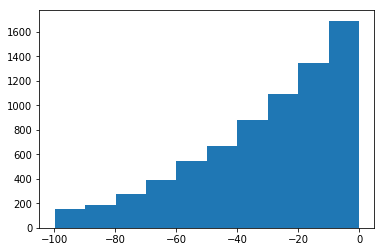

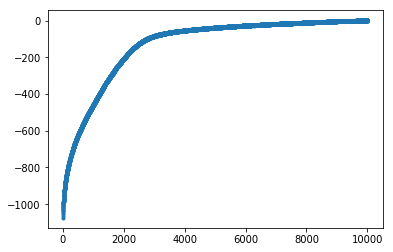

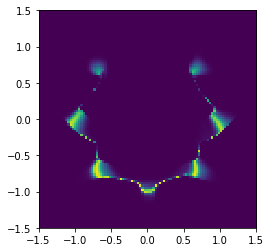

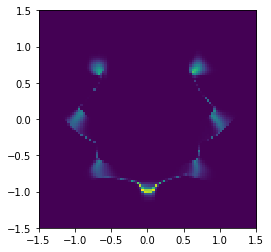

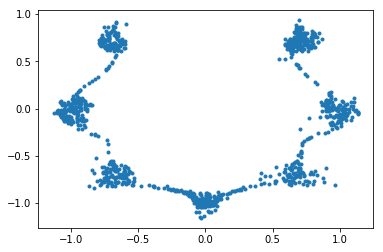

In [28]:
# View heatmap for FlowGAN mixture of gaussians trained on 7 means
net = getModels('mogNVP')[0]
net.load_state_dict(torch.load('generated/final/mog_flowgan_seven/netG_10.pth', lambda s,t:s))
heatmapFlowgan(net, codesOnly=True, savePrefix='allPlotsFinal/flowgan_mog')
plotMogSamplesFlowgan(net, 1000, savePrefix='allPlotsFinal/flowgan_mog')

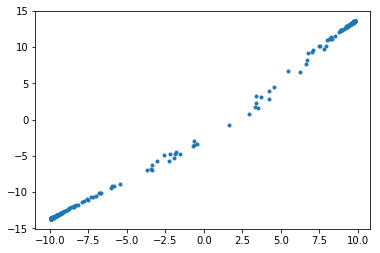

In [8]:
# Sampled points for regular mog-GAN mixture of gaussians trained on 7 means
# This simply doesn't work, no matter what I try
# Will not use these results
# beta1 = 0.9, mog_sohil
# This is like Sohil's results
# Neither sohil gan nor infogan worked
# BiGAN probably works, but etc....
net = getModels('mogInfogan')[0]
net.load_state_dict(torch.load('generated/final/mog_infogan/netG_10.pth', lambda s,t:s))
#heatmap(net)
plotMogSamples(net, 1000)

4514.0 4515.0 4514.6514


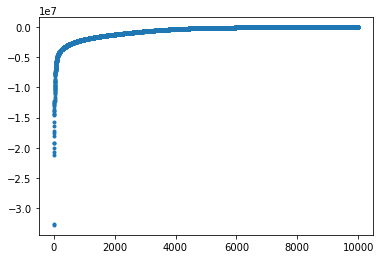

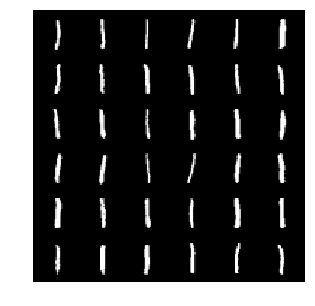

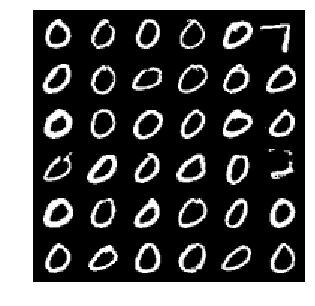

In [17]:
# FlowGAN with ones, on real MNIST.
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/mnist_fulltrain.mat')
ims = m['images']
probs = m['probs'].squeeze()
codeProbs = m['codeProbs'].squeeze()

jacob = probs-codeProbs
print jacob.min(), jacob.max(), jacob.mean()
plt.figure()
codeSortInds = np.argsort(codeProbs)
plt.plot(probs[codeSortInds],'.')
plt.savefig('allPlotsFinal/flowgan/logprobs_cross_sorted.pdf', dpi=500)

ims = ims.reshape((-1,28,28,1))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_mnist_real.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_mnist_real.png')

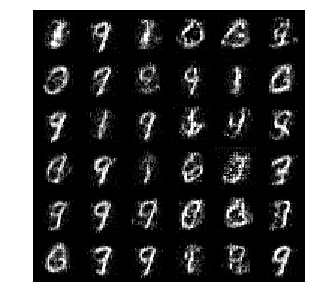

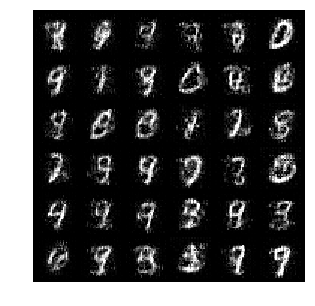

In [31]:
# FlowGAN samples (with ones).
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/mnist_fulltrain_samples.mat')
ims = m['images']
#probs = m['probs'].squeeze()
probs = m['codeProbs'].squeeze()

ims = ims.reshape((-1,28,28,1))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims).clamp(0,1)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_mnist_sample.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_mnist_sample.png')

0 -65031.695 -2820.079
1 -3659.5835 -2858.948
2 -12454.394 -2900.549
3 -8970.121 -2813.7239
4 -4863.293 -2709.4448
5 -7155.2163 -3008.8325
6 -7129.8975 -2925.1785
7 -6961.5635 -2720.9866
8 -5370.1313 -2824.745
9 -5251.8584 -2804.2979


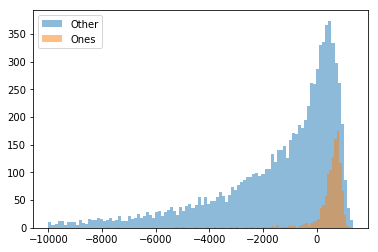

4060.9844 4061.0 4060.9849
10000


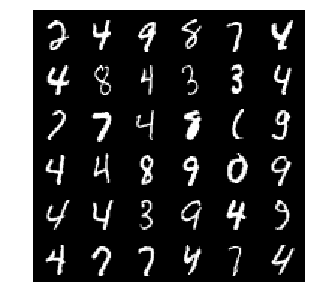

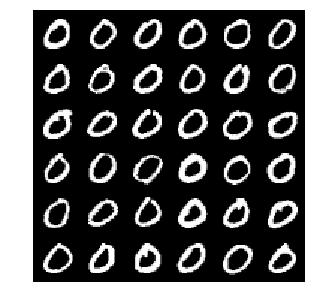

In [40]:
# FlowGAN WITHOUT ones, on real MNIST.
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/mnist_no_ones_fulltrain_on_ones.mat')
ims = m['images']
probs = m['probs'].squeeze()
codeProbs = m['codeProbs'].squeeze()

mnist = getLoaders('mnist', datasetOnly=True, mode='test')
Y = mnist.Y.squeeze()
for i in np.unique(Y):
    print i, np.mean(codeProbs[Y==i]), np.max(codeProbs[Y==i])
plt.figure()
plt.hist(probs[(Y!=1)&(probs>-10000)], bins=100, alpha=0.5, label='Other')
plt.hist(probs[(Y==1)&(probs>-10000)], bins=100, alpha=0.5, label='Ones')
plt.legend()
plt.show()
plt.savefig('allPlotsFinal/flowgan/histogram_mnist_no_ones_on_mnist.pdf', dpi=500)

jacob = probs-codeProbs
print jacob.min(), jacob.max(), jacob.mean()
#plt.figure()
#codeSortInds = np.argsort(codeProbs)
#plt.plot(probs[codeSortInds],'.')

print len(ims)

ims = ims.reshape((-1,28,28,1))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_mnist_no_ones_real.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_mnist_no_ones_real.png')

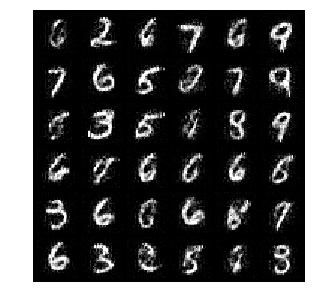

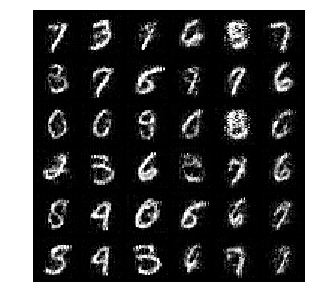

In [41]:
# FlowGAN samples (WITHOUT ones).
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/mnist_no_ones_fulltrain_samples.mat')
ims = m['images']
#probs = m['probs'].squeeze()
probs = m['codeProbs'].squeeze()

ims = ims.reshape((-1,28,28,1))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims).clamp(0,1)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_mnist_no_ones_sample.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_mnist_no_ones_sample.png')

codeProbs
labels
__header__
__globals__
images
__version__
probs
4420.452 263418.84 5669.476


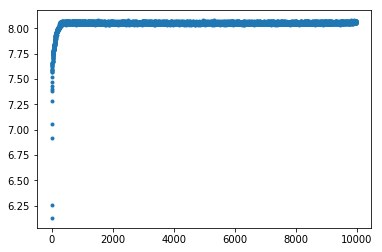

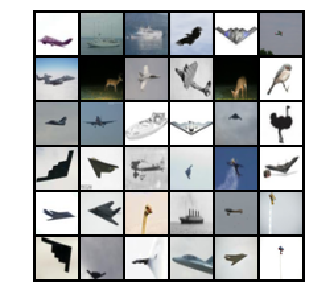

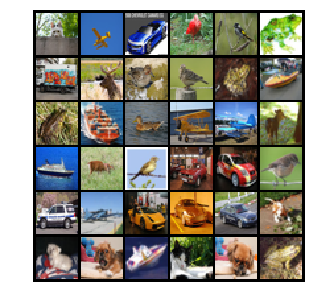

In [46]:
# Flowgan Cifar on real cifar.
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/cifar_muchtrain.mat')
for k in m:
    print k
ims = m['images']
probs = m['probs'].squeeze()
codeProbs = m['codeProbs'].squeeze()

jacob = probs-codeProbs
print jacob.min(), jacob.max(), jacob.mean()
plt.figure()
codeSortInds = np.argsort(codeProbs)
plt.plot(probs[codeSortInds],'.')
plt.savefig('allPlotsFinal/flowgan/cifar_logprobs_cross_sorted.pdf', dpi=500)

ims = ims.reshape((-1,32,32,3))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_cifar_real.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_cifar_real.png')

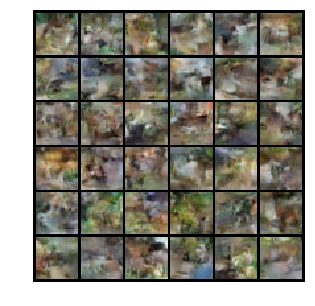

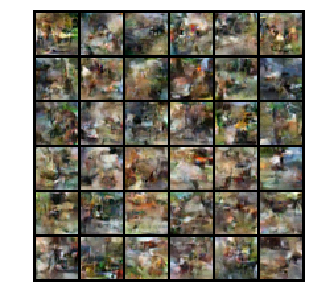

In [47]:
# FlowGAN cifar samples
# Load flowGAN mnist samples and view them
m = loadmat('/fs/vulcan-scratch/krusinga/externalProjects/sohilGAN/flow-gan-master/savedir/cifar_muchtrain_samples.mat')
ims = m['images']
#probs = m['probs'].squeeze()
probs = m['codeProbs'].squeeze()

ims = ims.reshape((-1,32,32,3))
#print ims.shape
ims = np.transpose(ims, (0,3,1,2))
ims = torch.from_numpy(ims).clamp(0,1)
#grid = vutils.make_grid(ims[:1024], nrow=32, normalize=False)#.clamp(0,1)
#plt.figure(figsize=(15,15))
#plt.imshow(grid.numpy().transpose((1,2,0)))

probSortInds = np.argsort(probs)
topIms = ims[probSortInds[-36:]]
botIms = ims[probSortInds[:36]]
topGrid = vutils.make_grid(topIms, nrow=6)
botGrid = vutils.make_grid(botIms, nrow=6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(topGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/top_flowgan_cifar_sample.png')
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(botGrid.numpy().transpose(1,2,0))
plt.savefig('allPlotsFinal/flowgan/bottom_flowgan_cifar_sample.png')

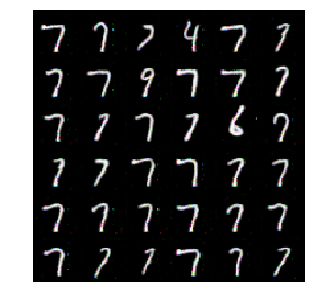

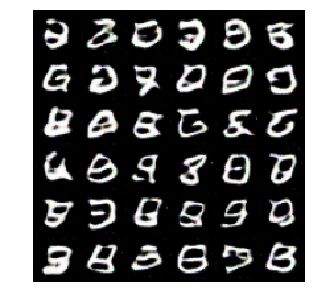

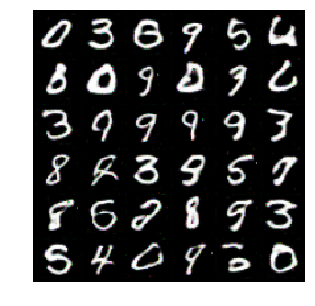

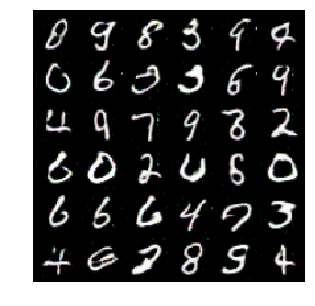

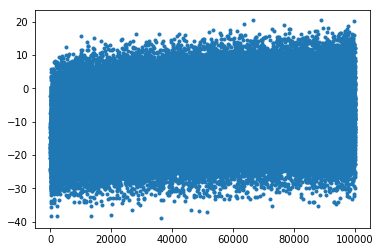

In [52]:
# Visualize infogan samples for mnist with no ones
m = loadmat('generated/final/infogan/mnist/no_ones/numerical_samples/samples.mat')
hiLow(m, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/mnist/no_ones_pixel_sample')
hiLow(m, useCodeProbs=True, savePrefix='allPlotsFinal/infogan/mnist/no_ones_codes_sample')
sortPlot(m['codeProbs'].squeeze(), m['probs'].squeeze())
plt.savefig('allPlotsFinal/infogan/mnist/logprob_cross_sorted_mnist_no_ones.pdf',dpi=500)

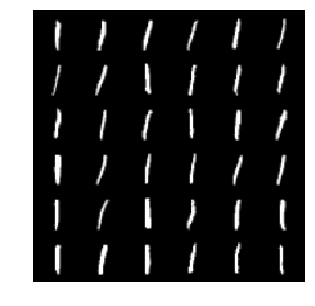

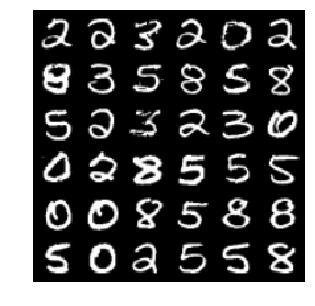

In [53]:
# Visualize real mnist PIXEL predictions for mnist with no ones
m = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTestPixel.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/mnist/no_ones_codes_real')

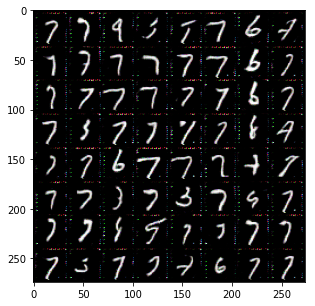

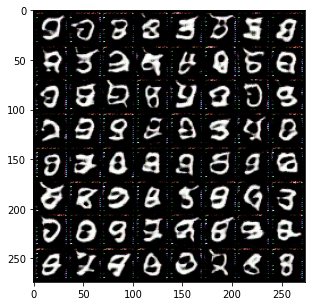

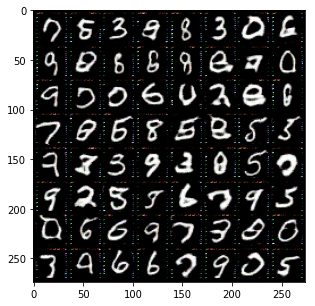

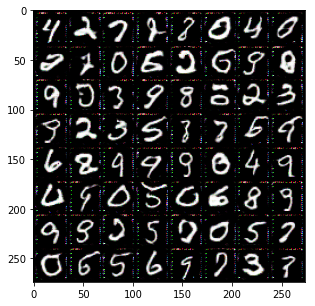

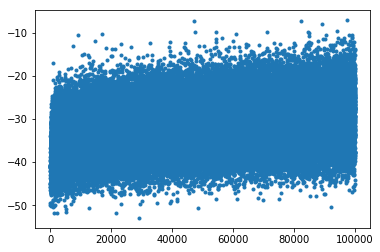

In [32]:
# Visualize infogan samples for mnist with ones
m = loadmat('generated/final/infogan/mnist/standard/numerical_samples/samples.mat')
hiLow(m, useCodeProbs=False, resolution=5)
hiLow(m, useCodeProbs=True, resolution=5)
sortPlot(m['codeProbs'].squeeze(), m['probs'].squeeze())

0 -43.478268
1 -43.97719
2 -44.891804
3 -44.250256
4 -44.84907
5 -44.64103
6 -43.585518
7 -44.564407
8 -44.651997
9 -43.99386


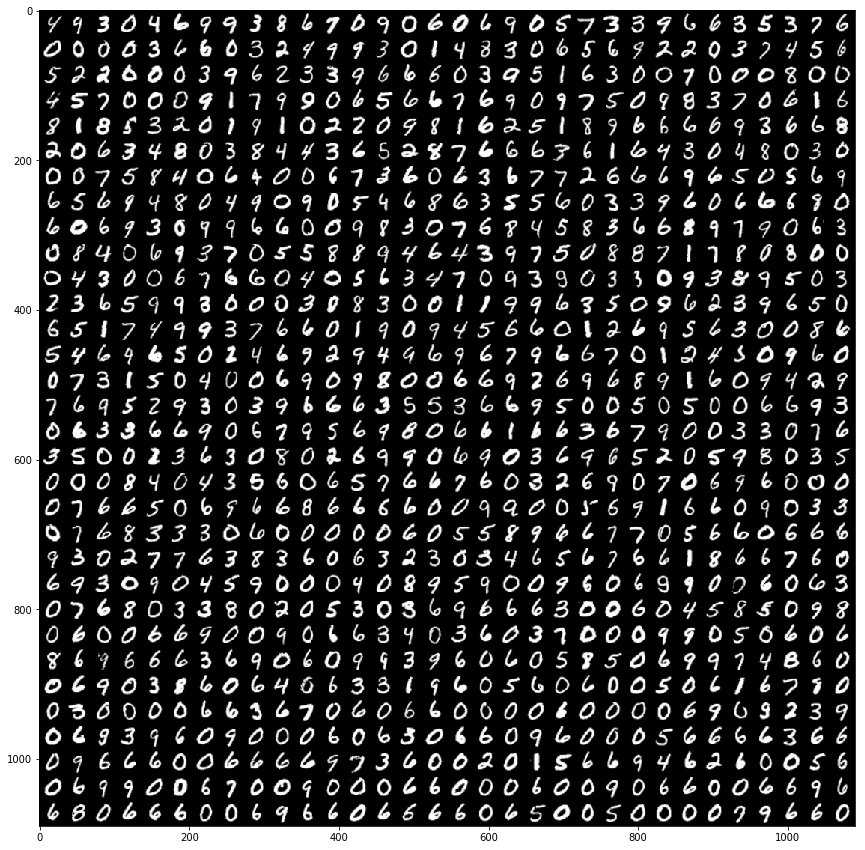

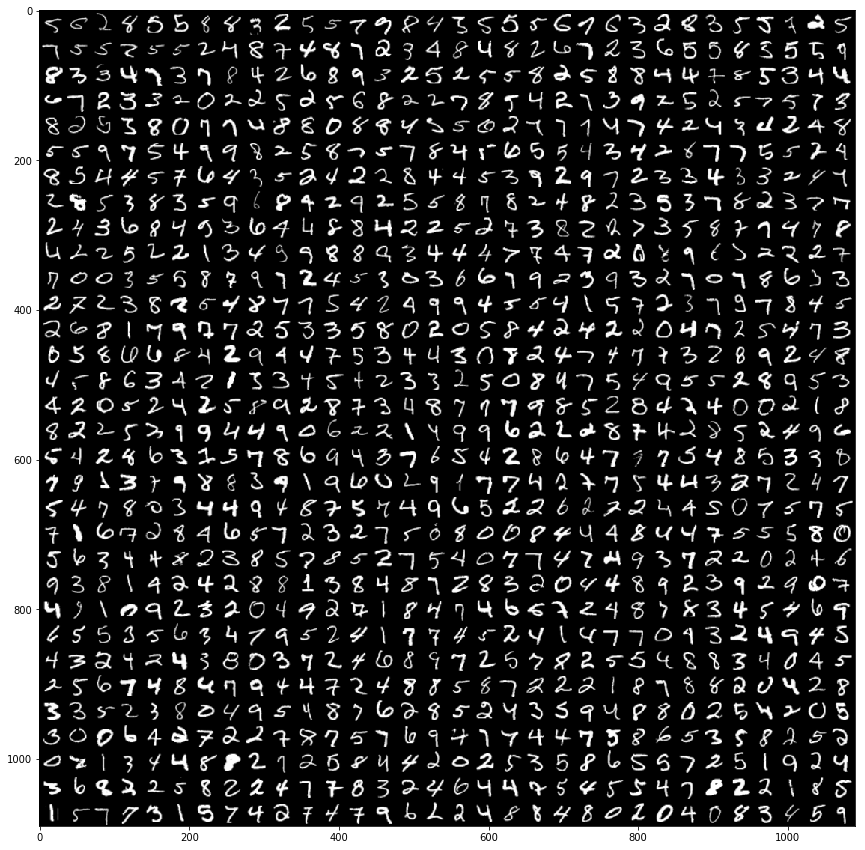

In [44]:
# Visualize real mnist INFOGAN EMBEDDING predictions for mnist with no ones
m = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTestEmb.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
Y = mnist.Y
p = m['probs'].squeeze()
for i in range(10):
    print i, p[Y==i].mean()
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, number=1024, nrow=32, useCodeProbs=False, resolution=15)

0 -65.81456
1 -62.035633
2 -64.23586
3 -64.89604
4 -64.35261
5 -64.787766
6 -63.907825
7 -63.7166
8 -65.8192
9 -64.64016


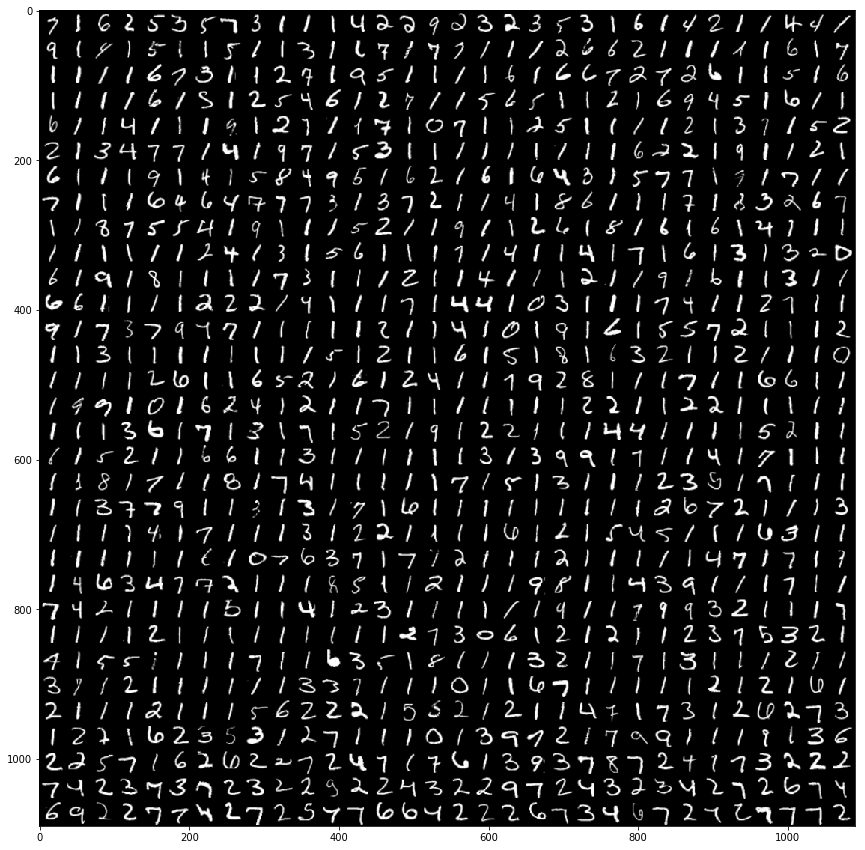

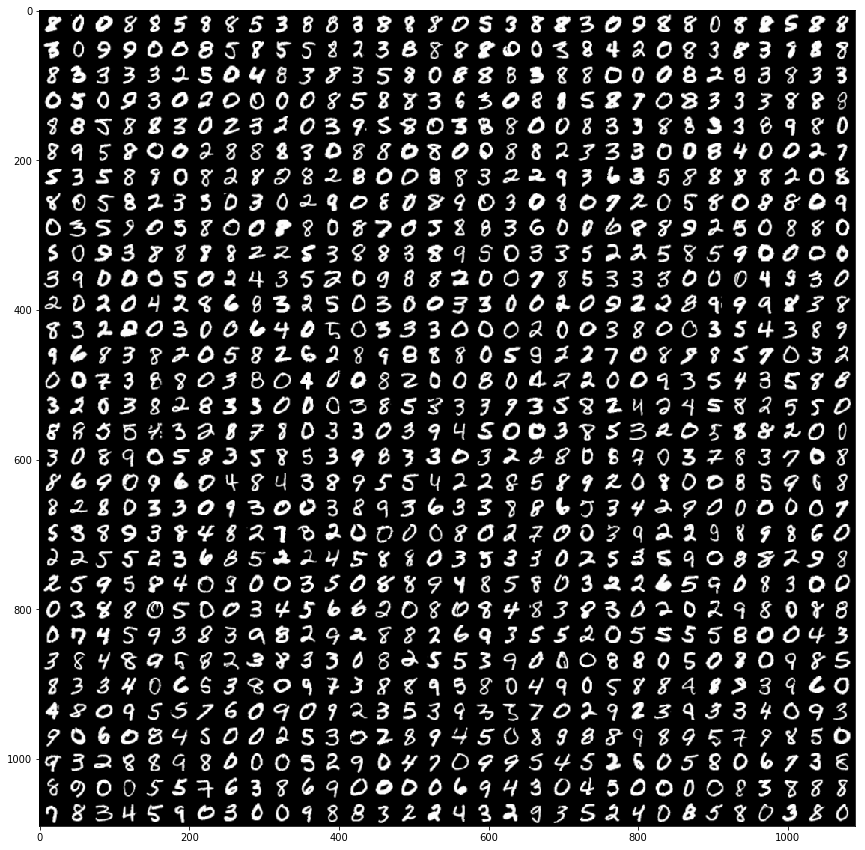

In [65]:
# Visualize real mnist PIXEL CODE REGRESSOR predictions for mnist with no ones
m = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTestCode.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
Y = mnist.Y
p = m['probs'].squeeze()
for i in range(10):
    print i, p[Y==i].mean()
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, number=1024, nrow=32, useCodeProbs=False, resolution=15)

0 -62.80217
1 -61.341866
2 -61.957207
3 -61.88897
4 -62.16525
5 -62.183243
6 -61.93274
7 -62.423485
8 -62.602623
9 -62.513435


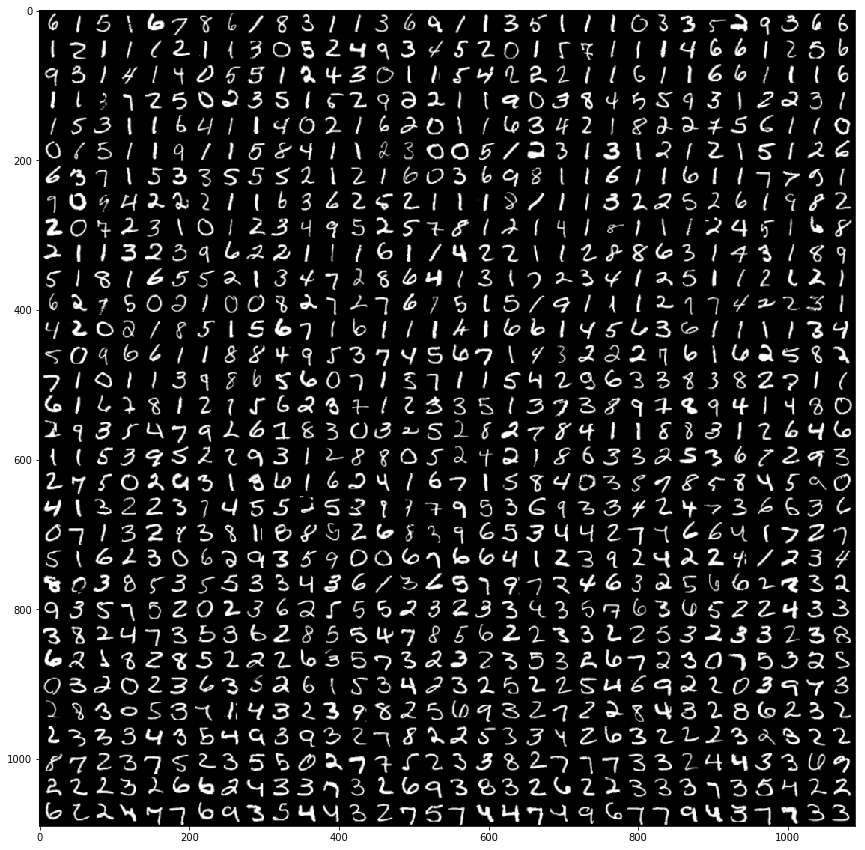

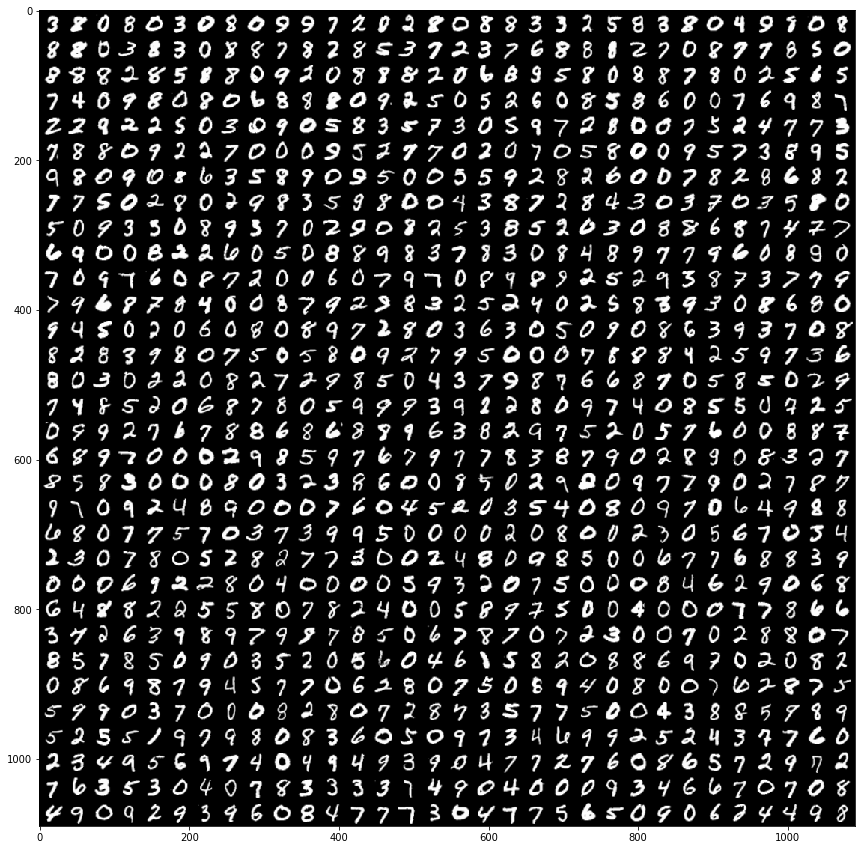

In [4]:
# Visualize real mnist PIXEL CODE REGRESSOR TWO SIDED predictions for mnist with no ones
m = loadmat('generated/final/infogan/mnist/no_ones/data_samples/mnistTestTwoSidedCode.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
Y = mnist.Y
p = m['probs'].squeeze()
p = p-2*np.maximum(p-2,0)
for i in range(10):
    print i, p[Y==i].mean()
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, number=1024, nrow=32, useCodeProbs=False, resolution=15)

-66.49274 -43.042572 -52.92247
0 -48.666824
1 -58.749275
2 -52.58752
3 -52.47021
4 -54.08947
5 -52.26555
6 -52.734585
7 -53.618855
8 -51.766674
9 -51.400436


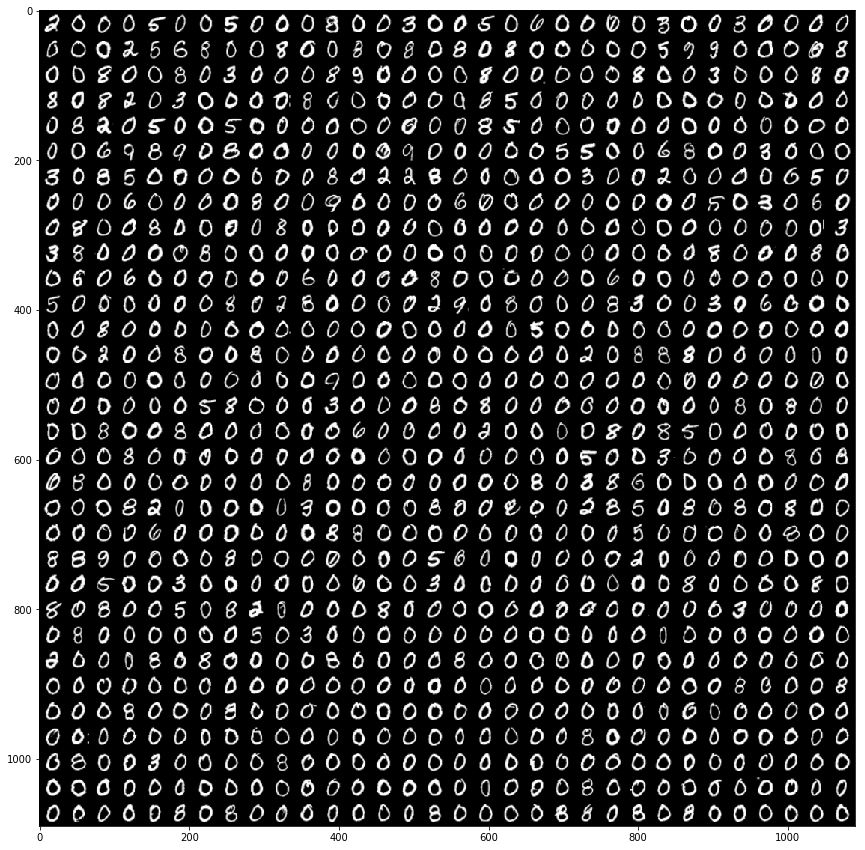

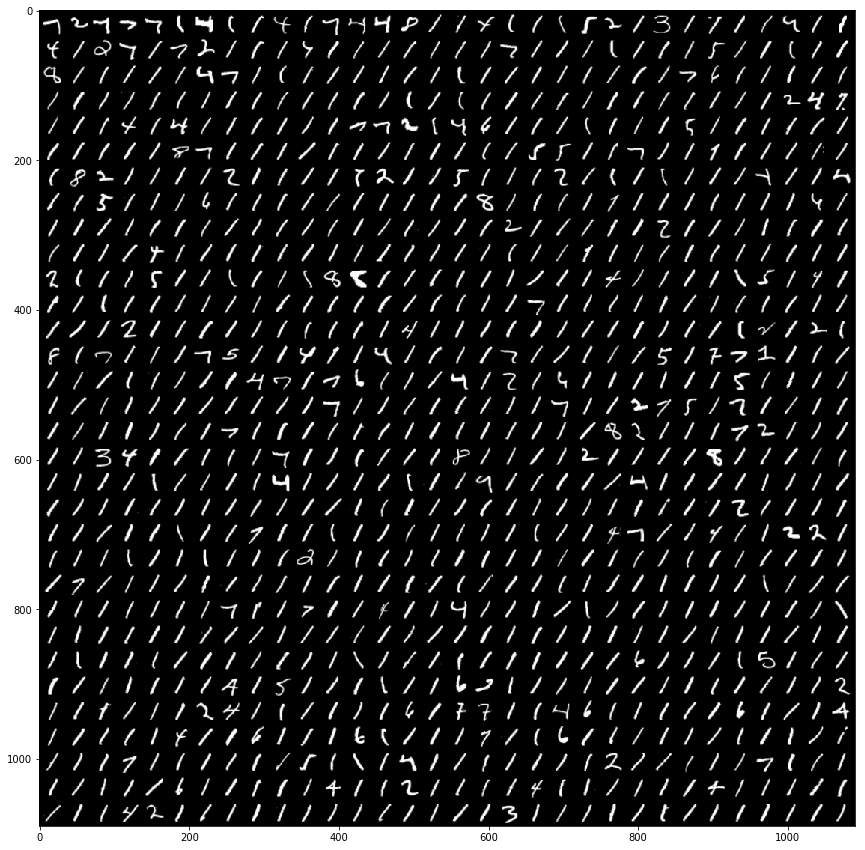

In [66]:
# An INFOGAN MNIST NO ONES run that worked, for some reason
m = getLoaders('mnist', datasetOnly=True)
p = loadmat('generated/final/infogan_mnist_no_ones/mnist/mnist.mat')['probs']
print p.min(), p.max(), p.mean()
Y = m.Y
p = p.squeeze()
for i in range(10):
    print i, p[Y==i].mean()
hiLow({'images':m.X, 'probs':p}, number=1024, nrow=32)#, classes=Y)

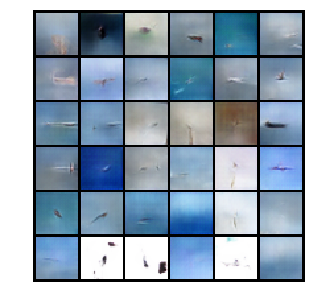

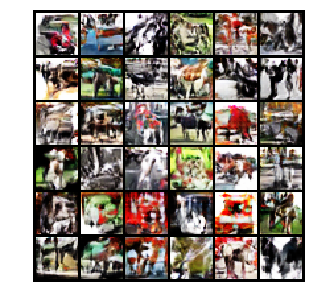

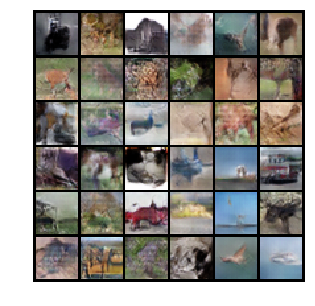

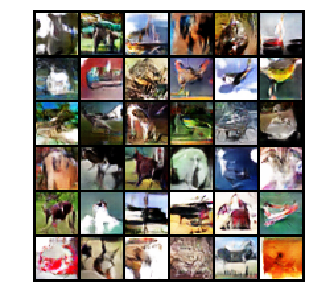

In [69]:
# Visualize infogan samples for cifar
m = loadmat('generated/final/infogan/cifar/standard/numerical_samples/samples.mat')
hiLow(m, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/cifar/samples_prob_sort')
hiLow(m, useCodeProbs=True, savePrefix='allPlotsFinal/infogan/cifar/samples_code_sort')
#sortPlot(m['codeProbs'].squeeze(), m['probs'].squeeze())

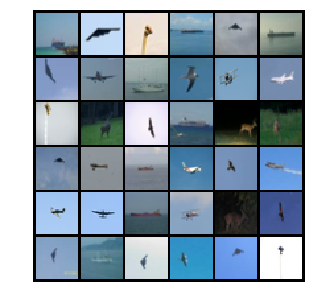

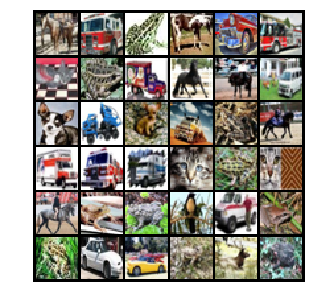

In [65]:
# Visualize real cifar PIXEL predictions 
m = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestPixel.mat')
mnist = getLoaders('cifar10', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/cifar/pixel')

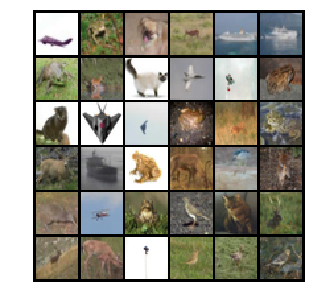

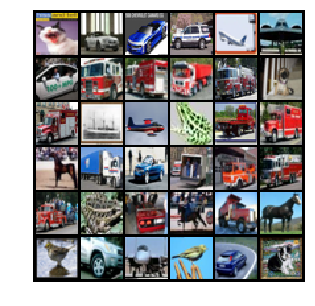

In [66]:
# Visualize real cifar INFOGAN EMBEDDING predictions 
m = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestEmb.mat')
mnist = getLoaders('cifar10', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/cifar/embedding')

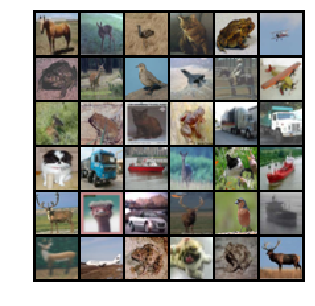

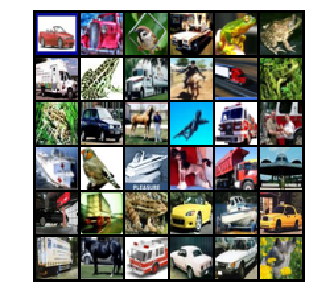

In [68]:
# Visualize real cifar PIXEL CODE predictions 
m = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTestCode.mat')
mnist = getLoaders('cifar10', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, savePrefix='allPlotsFinal/infogan/cifar/code')

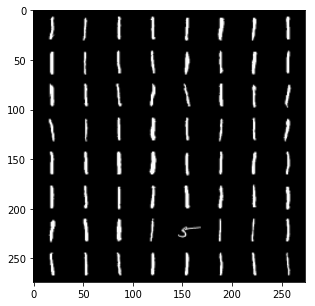

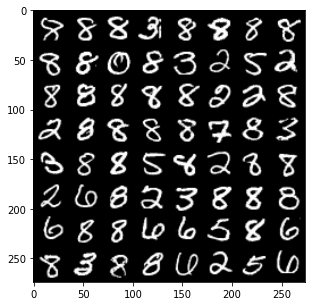

In [48]:
# Visualize real mnist UNDER CIFAR PIXEL predictions 
m = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTestPixel.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, resolution=5)

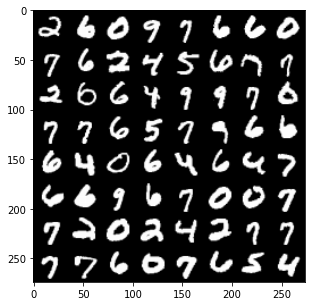

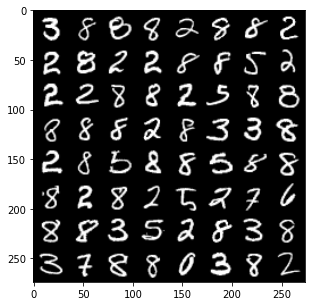

In [49]:
# Visualize real mnist UNDER CIFAR Emb predictions 
m = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTestEmb.mat')
mnist = getLoaders('mnist', datasetOnly=True, mode='test')
hiLow({'images':mnist.X, 'probs':m['probs'].squeeze()}, useCodeProbs=False, resolution=5)

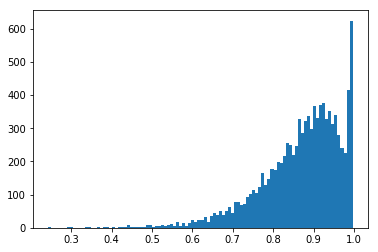

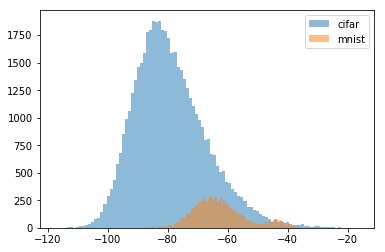

In [61]:
# MNIST percentiles under Cifar PIXEL regressor
test = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTestPixel.mat')
train = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainPixel.mat')
percentiles(train['probs'].squeeze(), test['probs'].squeeze(), savePrefix='allPlotsFinal/infogan/cifar/pixel/mnist')
histogramOverlap(train['probs'].squeeze(), test['probs'].squeeze(), trainLabel='cifar',
                 testLabel='mnist', savePrefix='allPlotsFinal/infogan/cifar/pixel/mnist')

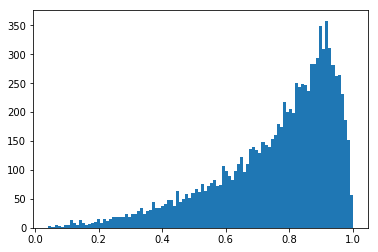

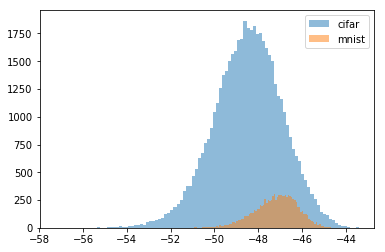

In [60]:
# MNIST percentiles under Cifar INFOGAN EMBEDDING regressor
test = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTestEmb.mat')
train = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainEmb.mat')
percentiles(train['probs'].squeeze(), test['probs'].squeeze(), savePrefix='allPlotsFinal/infogan/cifar/embedding/mnist')
histogramOverlap(train['probs'].squeeze(), test['probs'].squeeze(), trainLabel='cifar',
                 testLabel='mnist', savePrefix='allPlotsFinal/infogan/cifar/embedding/mnist')

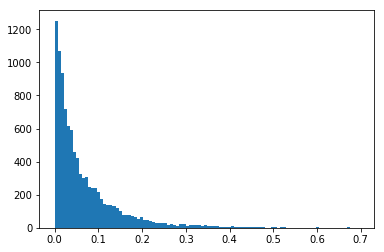

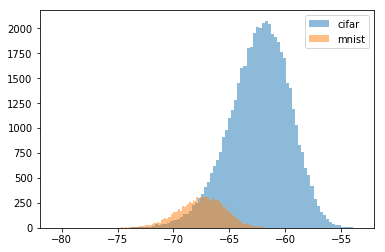

In [59]:
# MNIST percentiles under Cifar PIXEL CODE regressor
test = loadmat('generated/final/infogan/cifar/standard/data_samples/mnistTestCode.mat')
train = loadmat('generated/final/infogan/cifar/standard/data_samples/cifarTrainCode.mat')
percentiles(train['probs'].squeeze(), test['probs'].squeeze(), savePrefix='allPlotsFinal/infogan/cifar/code/mnist')
histogramOverlap(train['probs'].squeeze(), test['probs'].squeeze(), trainLabel='cifar',
                 testLabel='mnist', savePrefix='allPlotsFinal/infogan/cifar/code/mnist')

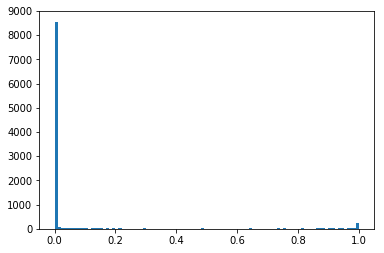

In [63]:
# Cifar percentiles under MNIST PIXEL regressor
test = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTestPixel.mat')
train = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainPixel.mat')
percentiles(train['probs'].squeeze(), test['probs'].squeeze())

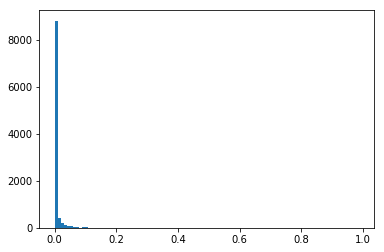

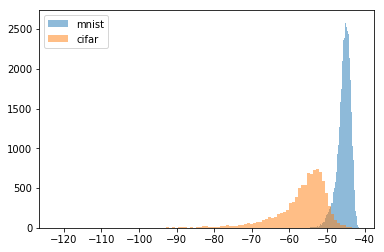

In [62]:
# Cifar percentiles under MNIST INFOGAN EMBEDDING regressor
test = loadmat('generated/final/infogan/mnist/standard/data_samples/cifarTestEmb.mat')
train = loadmat('generated/final/infogan/mnist/standard/data_samples/mnistTrainEmb.mat')
percentiles(train['probs'].squeeze(), test['probs'].squeeze(), savePrefix='allPlotsFinal/infogan/mnist/embedding/cifar')
histogramOverlap(train['probs'].squeeze(), test['probs'].squeeze(), trainLabel='mnist', testLabel='cifar', savePrefix='allPlotsFinal/infogan/mnist/embedding/cifar')